In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Union
from scipy import ndimage, signal
from scipy.optimize import curve_fit
from scipy.stats import describe
import cv2
import warnings
warnings.filterwarnings('ignore')

# ==================== 文件读取模块 ====================

def read_tiff_to_df(filepath: str) -> Tuple[pd.DataFrame, dict]:
    """
    读取TIFF文件并转换为DataFrame
    
    Args:
        filepath: TIFF文件路径
        
    Returns:
        tuple: (DataFrame, metadata_dict)
    """
    try:
        # 使用PIL读取TIFF文件
        with Image.open(filepath) as img:
            # 获取图片基本信息
            metadata = {
                'filename': filepath,
                'size': img.size,
                'mode': img.mode,
                'format': img.format,
                'width': img.width,
                'height': img.height
            }
            
            # 如果有EXIF信息，也添加进去
            if hasattr(img, '_getexif') and img._getexif():
                metadata['exif'] = img._getexif()
            
            # 转换为numpy数组
            img_array = np.array(img)
            
            # 如果是彩色图像，转换为灰度
            if len(img_array.shape) == 3:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
                metadata['converted_to_grayscale'] = True
            
            # 转换为DataFrame
            df = pd.DataFrame(img_array)
            
        return df, metadata
        
    except Exception as e:
        print(f"读取TIFF文件失败: {e}")
        return pd.DataFrame(), {}

def read_image_to_df(filepath: str) -> Tuple[pd.DataFrame, dict]:
    """
    通用图像文件读取函数，支持多种格式
    
    Args:
        filepath: 图像文件路径
        
    Returns:
        tuple: (DataFrame, metadata_dict)
    """
    try:
        # 使用PIL读取图像
        with Image.open(filepath) as img:
            metadata = {
                'filename': filepath,
                'size': img.size,
                'mode': img.mode,
                'format': img.format,
                'width': img.width,
                'height': img.height
            }
            
            # 转换为numpy数组
            img_array = np.array(img)
            
            # 如果是彩色图像，转换为灰度
            if len(img_array.shape) == 3:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
                metadata['converted_to_grayscale'] = True
            
            # 转换为DataFrame
            df = pd.DataFrame(img_array)
            
        return df, metadata
        
    except Exception as e:
        print(f"读取图像文件失败: {e}")
        return pd.DataFrame(), {}

# ==================== 图像处理类 ====================

@dataclass
class ImageProcessor:
    """
    2D图像处理类
    
    该类提供了完整的2D DataFrame处理功能，包括：
    - 数据可视化和亮度调整
    - 数据切割和降维
    - 背景校正
    - 图像旋转和ROI选择
    - 数据导出功能
    
    Attributes:
        original_data: 原始2D DataFrame数据
        metadata: 数据元信息字典
        sliced_blocks: 切割后的数据块列表
        integrated_blocks: 降维后的数据列表
        brightness_range: 当前亮度范围 (min, max)
        background_data: 背景数据DataFrame
        background_corrected: 是否已进行背景校正的标志
        processed_data: 背景校正后的数据（如果进行了校正）
        current_data: 当前工作数据
        roi_list: 存储所有ROI截取结果的列表  # 重命名后的属性
    """
    original_data: pd.DataFrame
    metadata: dict = field(default_factory=dict)
    sliced_blocks: List[pd.DataFrame] = field(default_factory=list)
    integrated_blocks: List[pd.DataFrame] = field(default_factory=list)
    brightness_range: Tuple[float, float] = field(default_factory=lambda: (0, 255))
    # background related
    background_data: pd.DataFrame = field(default_factory=pd.DataFrame)
    background_corrected: bool = False
    processed_data: pd.DataFrame = field(default_factory=pd.DataFrame)
    current_data: pd.DataFrame = field(default_factory=pd.DataFrame)
    # ROI related
    roi_list: List[pd.DataFrame] = field(default_factory=list)

    # filename_related
    filename: str = field(default="")  # 存储当前数据的文件名
    background_filename: str = field(default="")  # 存储背景数据的文件名

    def __post_init__(self):
        """初始化后处理，设置默认亮度范围和当前数据"""
        if not self.original_data.empty:
            self.brightness_range = (
                float(self.original_data.min().min()),
                float(self.original_data.max().max())
            )
            self.current_data = self.original_data.copy()
        
        # 从metadata中提取文件名
        if self.metadata and 'filename' in self.metadata:
            import os
            self.filename = os.path.basename(self.metadata['filename'])

    def _extract_filename(self, filepath: str) -> str:
        """从文件路径中提取文件名"""
        import os
        return os.path.basename(filepath) if filepath else "no_filename"
    
    def get_current_data(self, raw: bool = False) -> pd.DataFrame:
        """
        获取当前用于分析的数据
        
        Args:
            raw: 是否返回原始数据，默认False
        
        Returns:
            pd.DataFrame: 根据参数返回相应数据
        """
        if raw:
            return self.original_data
        elif self.background_corrected and not self.processed_data.empty:
            return self.processed_data
        else:
            return self.current_data if not self.current_data.empty else self.original_data
    
    def visualize_data(self, input_img=None, figsize: Tuple[int, int] = (10, 8), 
                      brightness_range: Optional[Tuple[float, float]] = None,
                      custom_filename: str = None) -> None:
        """
        可视化2D数据, 支持亮度范围调整, 通过 input_img允许临时调用
        
        Args:
            input_img: 允许此函数优先临时调用以可视化任意的2D数据
            figsize: 图像大小
            brightness_range: 亮度范围 (min, max), None表示使用默认范围
            custom_filename: 临时调用时的自定义文件名
        """
        # 优先可视化 input_img
        if input_img is not None:
            current_data = input_img
            display_filename = custom_filename if custom_filename else "temporary_data"
        else:
            current_data = self.get_current_data()
            display_filename = self.filename if self.filename else "no_filename"
        
        if current_data.empty:
            print("没有数据可视化")
            return
        
        if brightness_range:
            self.brightness_range = brightness_range
        else:
            # 重新计算当前数据的亮度范围
            self.brightness_range = (
                float(current_data.min().min()),
                float(current_data.max().max())
            )
        
        plt.figure(figsize=figsize)
        plt.imshow(current_data.values, 
                  cmap='gray', 
                  vmin=self.brightness_range[0], 
                  vmax=self.brightness_range[1], 
                  origin='lower')
        plt.colorbar(label='Intensity')
        
        # 构建标题，包含文件名
        title = f'{display_filename} - 2D Image Data'
        if self.background_corrected and input_img is None:  # 只对主数据显示背景校正状态
            title += ' (Background Corrected)'
        title += f' (Range: {self.brightness_range[0]:.1f} - {self.brightness_range[1]:.1f})'
        
        plt.title(title)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
    
    def visualize_1d_data(self, input_data=None, figsize: Tuple[int, int] = (12, 6), take_avg: bool = True) -> None:
        """
        可视化1D数据，默认可视化整个sliced_blocks，但允许用户指定需要可视化的对象
        
        Args:
            input_data: 临时调用的1D数据，可以是单个Series/DataFrame或列表
            figsize: 图像大小
            take_avg: 对于2D DataFrame的处理方式，True时取平均，False时求和
        """
        plt.figure(figsize=figsize)
        
        # 定义颜色循环，提高多曲线可视性
        colors = plt.cm.tab10(np.linspace(0, 1, 10))
        
        if input_data is not None:
            # 临时调用模式
            if isinstance(input_data, (list, tuple)):
                data_list = input_data
            else:
                data_list = [input_data]
        else:
            # 默认模式：可视化所有integrated_blocks或sliced_blocks的处理结果
            if self.integrated_blocks:
                data_list = self.integrated_blocks
            elif self.sliced_blocks:
                # 根据take_avg参数决定对每个2D块的处理方式
                if take_avg:
                    # 对每个2D块取平均得到1D数据
                    data_list = [block.mean(axis=1) for block in self.sliced_blocks]
                else:
                    # 对每个2D块沿纵轴求和得到1D数据
                    data_list = [block.sum(axis=1) for block in self.sliced_blocks]
            else:
                print("没有可视化的1D数据")
                return
        
        # 绘制所有曲线
        for i, data in enumerate(data_list):
            if isinstance(data, pd.DataFrame):
                # 如果是DataFrame，根据take_avg参数处理
                if data.shape[1] == 1:
                    # 单列DataFrame直接取值
                    y_values = data.iloc[:, 0].values
                else:
                    # 多列DataFrame根据参数选择处理方式
                    if take_avg:
                        y_values = data.mean(axis=1).values
                    else:
                        y_values = data.sum(axis=1).values
            elif isinstance(data, pd.Series):
                y_values = data.values
            else:
                y_values = np.array(data)
            
            x_values = np.arange(len(y_values))
            color = colors[i % len(colors)]
            
            # 根据处理方式调整标签显示
            processing_method = "Avg" if take_avg else "Sum"
            plt.plot(x_values, y_values, 
                    color=color, 
                    linewidth=2, 
                    label=f'Data {i+1} ({processing_method})',
                    alpha=0.8)
        
        plt.xlabel('Position')
        plt.ylabel('Intensity')
        
        # 根据处理方式调整标题
        processing_info = "(Average)" if take_avg else "(Sum)"
        plt.title(f'1D Data Visualization {processing_info}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 确保原点在左下
        plt.gca().invert_yaxis()
        plt.gca().invert_yaxis()  # 双重反转回到正确方向
        
        plt.tight_layout()
        plt.show()
    
    def rotate_data(self, angle: int) -> None:
        """
        旋转整个DataFrame
        
        Args:
            angle: 旋转角度，只支持90, 180, 270度
        """
        if angle not in [90, 180, 270]:
            print("旋转角度只支持90, 180, 270度")
            return
        
        current_data = self.get_current_data()
        if current_data.empty:
            print("没有数据可旋转")
            return
        
        # 转换为numpy数组进行旋转
        data_array = current_data.values
        
        if angle == 90:
            # 逆时针旋转90度
            rotated_array = np.rot90(data_array, k=1)
        elif angle == 180:
            # 旋转180度
            rotated_array = np.rot90(data_array, k=2)
        elif angle == 270:
            # 逆时针旋转270度（等于顺时针90度）
            rotated_array = np.rot90(data_array, k=3)
        
        # 转换回DataFrame并更新current_data
        self.current_data = pd.DataFrame(rotated_array)
        print(f"数据已旋转{angle}度，新尺寸: {self.current_data.shape}")
    
    def adjust_brightness_range(self, min_val: float, max_val: float) -> None:
        """
        调整图像亮度范围
        
        Args:
            min_val: 最小亮度值
            max_val: 最大亮度值
        """
        self.brightness_range = (min_val, max_val)
        print(f"亮度范围已调整为: {min_val} - {max_val}")
    
    def save_as_image(self, filepath: str, format: str = 'PNG') -> None:
        """
        保存当前亮度设置的图像为标准图像格式
        
        Args:
            filepath: 保存路径
            format: 图像格式 ('PNG', 'JPEG', 'TIFF')
        """
        current_data = self.get_current_data()
        if current_data.empty:
            print("没有数据可保存")
            return
        
        # 归一化数据到0-255范围
        data = current_data.values.copy()
        data = np.clip(data, self.brightness_range[0], self.brightness_range[1])
        data = ((data - self.brightness_range[0]) / 
                (self.brightness_range[1] - self.brightness_range[0]) * 255).astype(np.uint8)
        
        # 保存图像
        img = Image.fromarray(data, mode='L')
        img.save(filepath, format=format)
        print(f"图像已保存为: {filepath}")
    
    def save_as_csv(self, filepath: str) -> None:
        """
        保存DataFrame为CSV格式
        
        Args:
            filepath: CSV文件保存路径
        """
        current_data = self.get_current_data()
        if current_data.empty:
            print("没有数据可保存")
            return
        
        current_data.to_csv(filepath, index=False)
        print(f"数据已保存为CSV: {filepath}")
    
    def save_as_parquet(self, filepath: str) -> None:
        """
        保存DataFrame为Parquet格式（推荐用于大数据）
        
        Args:
            filepath: Parquet文件保存路径
        """
        current_data = self.get_current_data()
        if current_data.empty:
            print("没有数据可保存")
            return
        
        try:
            current_data.to_parquet(filepath, index=False)
            print(f"数据已保存为Parquet: {filepath}")
        except ImportError:
            print("需要安装pyarrow或fastparquet来保存Parquet格式")
            print("可以使用: pip install pyarrow")

    def slice_data(self, axis: str, start: int, end: int, step: int) -> None:
        """
        切割数据为N个数据块
        
        Args:
            axis: 切割轴 ('x' 或 'y')
            start: 起始坐标
            end: 结束坐标
            step: 步长
        """
        current_data = self.get_current_data()
        
        if current_data.empty:
            print("没有数据可切割")
            return
        
        self.sliced_blocks.clear()
        
        if axis.lower() == 'x':
            # 沿X轴切割（列方向）
            for i in range(start, end, step):
                if i + step <= current_data.shape[1]:
                    block = current_data.iloc[:, i:i+step].copy()
                    self.sliced_blocks.append(block)
        elif axis.lower() == 'y':
            # 沿Y轴切割（行方向）
            for i in range(start, end, step):
                if i + step <= current_data.shape[0]:
                    block = current_data.iloc[i:i+step, :].copy()
                    self.sliced_blocks.append(block)
        else:
            print("轴参数错误，请使用 'x' 或 'y'")
            return
        
        data_type = "背景校正后" if self.background_corrected else "当前"
        print(f"{data_type}数据已切割为 {len(self.sliced_blocks)} 个块，沿 {axis.upper()} 轴")

    def integrate_blocks_along_dimension(self, direction: str) -> None:
        """
        对数据块进行降维处理（求和）
        
        Args:
            direction: 降维方向 ('x' 或 'y')
        """
        if not self.sliced_blocks:
            print("没有切割的数据块可处理")
            return
        
        self.integrated_blocks.clear()
        
        for i, block in enumerate(self.sliced_blocks):
            if direction.lower() == 'x':
                # 沿X轴求和（每行求和）
                integrated = block.sum(axis=1)
            elif direction.lower() == 'y':
                # 沿Y轴求和（每列求和）
                integrated = block.sum(axis=0)
            else:
                print("方向参数错误，请使用 'x' 或 'y'")
                return
            
            self.integrated_blocks.append(integrated)
        
        print(f"已对 {len(self.integrated_blocks)} 个数据块沿 {direction.upper()} 方向进行降维")
    
    def analyze_blocks_statistics(self) -> Dict[int, dict]:
        """
        对数据块进行统计分析
        
        Returns:
            dict: 每个数据块的统计信息
        """
        if not self.sliced_blocks:
            print("没有切割的数据块可分析")
            return {}
        
        stats_results = {}
        
        for i, block in enumerate(self.sliced_blocks):
            data = block.values.flatten()
            stats = describe(data)
            
            stats_info = {
                'mean': float(stats.mean),
                'variance': float(stats.variance),
                'std': float(np.sqrt(stats.variance)),
                'min': float(stats.minmax[0]),
                'max': float(stats.minmax[1]),
                'skewness': float(stats.skewness),
                'kurtosis': float(stats.kurtosis),
                'size': int(stats.nobs)
            }
            
            stats_results[i] = stats_info
            
            print(f"数据块 {i} 统计信息:")
            print(f"  均值: {stats_info['mean']:.3f}")
            print(f"  标准差: {stats_info['std']:.3f}")
            print(f"  方差: {stats_info['variance']:.3f}")
            print(f"  范围: [{stats_info['min']:.3f}, {stats_info['max']:.3f}]")
            print(f"  偏度: {stats_info['skewness']:.3f}")
            print(f"  峰度: {stats_info['kurtosis']:.3f}")
            print("-" * 40)
        
        return stats_results

    # ======== Background Correction Methods ========
    def set_background_data(self, background_df: pd.DataFrame, 
                           background_filepath: str = "") -> bool:
        """
        设置背景数据并验证尺寸兼容性
        
        Args:
            background_df: 背景数据DataFrame
            background_filepath: 背景数据文件路径（用于提取文件名）
            
        Returns:
            bool: 尺寸是否匹配
        """
        if self.original_data.empty:
            print("错误：原始数据为空，无法设置背景")
            return False
            
        # 检查尺寸是否一致
        if background_df.shape == self.original_data.shape:
            self.background_data = background_df.copy()
            self.background_filename = self._extract_filename(background_filepath)
            print(f"背景数据已设置，尺寸: {background_df.shape}")
            if self.background_filename:
                print(f"背景文件: {self.background_filename}")
            return True
        else:
            print(f"警告：背景数据尺寸 {background_df.shape} 与原始数据尺寸 {self.original_data.shape} 不匹配")
            return False

    def remove_background(self, 
                         constant_value: Optional[float] = None,
                         region_coords: Optional[Tuple[int, int, int, int]] = None) -> bool:
        """
        去除背景噪声
        
        Args:
            constant_value: 恒定背景值（模式A）
            region_coords: 背景区域坐标 (row_start, row_end, col_start, col_end)（模式B）
            
        Returns:
            bool: 是否成功进行背景校正
        """
        if self.original_data.empty:
            print("错误：没有原始数据可处理")
            return False

        # 模式1：使用预设的背景数据
        if not self.background_data.empty and self.background_data.shape == self.original_data.shape:
            print("使用预设背景数据进行校正...")
            self.processed_data = self.original_data - self.background_data
            self.background_corrected = True
            print("背景校正完成（使用背景数据）")
            return True

        # 模式2A：使用恒定背景值
        elif constant_value is not None:
            print(f"使用恒定背景值 {constant_value} 进行校正...")
            self.processed_data = self.original_data - constant_value
            self.background_corrected = True
            print("背景校正完成（使用恒定值）")
            return True

        # 模式2B：使用指定区域的平均值作为背景
        elif region_coords is not None:
            try:
                row_start, row_end, col_start, col_end = region_coords
                
                # 验证坐标范围
                if (row_start < 0 or row_end > self.original_data.shape[0] or
                    col_start < 0 or col_end > self.original_data.shape[1] or
                    row_start >= row_end or col_start >= col_end):
                    print("错误：区域坐标超出数据范围或无效")
                    return False
                
                # 计算指定区域的平均值
                background_region = self.original_data.iloc[row_start:row_end, col_start:col_end]
                background_value = background_region.values.mean()
                
                print(f"从区域 [{row_start}:{row_end}, {col_start}:{col_end}] 计算背景值: {background_value:.3f}")
                
                # 执行背景校正
                self.processed_data = self.original_data - background_value
                self.background_corrected = True
                print("背景校正完成（使用区域平均值）")
                return True
                
            except Exception as e:
                print(f"区域背景计算失败: {e}")
                return False

        # 没有提供任何背景信息
        else:
            print("错误：必须提供以下之一进行背景校正：")
            print("1. 预先设置匹配尺寸的背景数据")
            print("2. 恒定背景值 (constant_value)")
            print("3. 背景区域坐标 (region_coords)")
            return False

    def visualize_background_correction(self, figsize: Tuple[int, int] = (15, 5)) -> None:
        """
        可视化背景校正前后的对比
        
        Args:
            figsize: 图像大小
        """
        if not self.background_corrected:
            print("尚未进行背景校正")
            return

        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # 原始数据
        im1 = axes[0].imshow(self.original_data.values, cmap='gray')
        original_title = f'{self.filename}\n原始数据' if self.filename else '原始数据'
        axes[0].set_title(original_title)
        axes[0].set_xlabel('X')
        axes[0].set_ylabel('Y')
        plt.colorbar(im1, ax=axes[0])
        
        # 背景数据（如果有）
        if not self.background_data.empty:
            im2 = axes[1].imshow(self.background_data.values, cmap='gray')
            bg_title = f'{self.background_filename}\n背景数据' if self.background_filename else '背景数据'
            axes[1].set_title(bg_title)
        else:
            # 显示背景校正的差值
            diff_data = self.original_data - self.processed_data
            im2 = axes[1].imshow(diff_data.values, cmap='gray')
            axes[1].set_title('移除的背景')
        axes[1].set_xlabel('X')
        axes[1].set_ylabel('Y')
        plt.colorbar(im2, ax=axes[1])
        
        # 校正后数据
        im3 = axes[2].imshow(self.processed_data.values, cmap='gray')
        corrected_title = f'{self.filename}\n背景校正后' if self.filename else '背景校正后'
        axes[2].set_title(corrected_title)
        axes[2].set_xlabel('X')
        axes[2].set_ylabel('Y')
        plt.colorbar(im3, ax=axes[2])
        
        plt.tight_layout()
        plt.show()

    def reset_background_correction(self) -> None:
        """
        重置背景校正，恢复到原始数据状态
        """
        self.background_corrected = False
        self.processed_data = pd.DataFrame()
        print("背景校正已重置")


    # ======== ROI Methods ========

    def select_roi(self, origin: Tuple[int, int], width: int, height: int, 
               replace_current_data: bool = False, 
               store_roi: bool = True,
               visualize: bool = True) -> pd.DataFrame:
        """
        用户手动输入ROI范围截取current_data
        
        Args:
            origin: ROI原点坐标 (x, y)
            width: ROI宽度
            height: ROI高度
            replace_current_data: 是否替换当前数据，默认False
            store_roi: 是否将ROI结果存储到roi_list中，默认True
            visualize: 是否可视化ROI结果，默认True
            
        Returns:
            pd.DataFrame: 截取的ROI数据
        """
        current_data = self.get_current_data()
        if current_data.empty:
            print("没有数据可截取")
            return pd.DataFrame()
        
        x, y = origin
        
        # 验证ROI范围
        if (x < 0 or y < 0 or 
            x + width > current_data.shape[1] or 
            y + height > current_data.shape[0]):
            print(f"ROI范围超出数据边界")
            print(f"数据尺寸: {current_data.shape}")
            print(f"ROI范围: ({x}, {y}) 到 ({x+width}, {y+height})")
            return pd.DataFrame()
        
        # 截取ROI（注意DataFrame的行列索引）
        roi_data = current_data.iloc[y:y+height, x:x+width].copy()
        
        # 存储ROI数据到类属性列表中（如果启用）
        if store_roi:
            self.roi_list.append(roi_data)
            roi_index = len(self.roi_list) - 1
            print(f"ROI已截取并存储为ROI #{roi_index}，尺寸: {roi_data.shape}")
            print(f"当前roi_list中共有 {len(self.roi_list)} 个ROI")
        else:
            print(f"ROI已截取，尺寸: {roi_data.shape}")
        
        print(f"ROI范围: ({x}, {y}) 到 ({x+width}, {y+height})")
        
        # 可视化ROI（如果启用）
        if visualize:
            self.visualize_data(input_img=roi_data)
        
        # 是否替换当前数据
        if replace_current_data:
            self.current_data = roi_data
            print("ROI数据已设置为当前工作数据")
        
        return roi_data

    def clear_roi_list(self) -> None:
        """
        清空roi_list中的所有ROI数据
        """
        roi_count = len(self.roi_list)
        self.roi_list.clear()
        print(f"roi_list已清空，删除了 {roi_count} 个ROI")

    def remove_roi(self, index: int) -> bool:
        """
        删除roi_list中指定索引的ROI数据
        
        Args:
            index: 要删除的ROI索引
            
        Returns:
            bool: 是否成功删除
        """
        if not self.roi_list:
            print("roi_list为空，没有ROI可删除")
            return False
        
        if 0 <= index < len(self.roi_list):
            removed_roi = self.roi_list.pop(index)
            print(f"已删除ROI #{index}，尺寸为 {removed_roi.shape}")
            print(f"当前roi_list中剩余 {len(self.roi_list)} 个ROI")
            
            # 重新编号提示
            if self.roi_list:
                print("剩余ROI重新编号为: ", end="")
                print(", ".join([f"#{i}" for i in range(len(self.roi_list))]))
            
            return True
        else:
            print(f"索引 {index} 超出范围 [0, {len(self.roi_list)-1}]")
            return False

    def remove_roi_range(self, start_index: int, end_index: int) -> bool:
        """
        删除roi_list中指定范围的ROI数据
        
        Args:
            start_index: 起始索引（包含）
            end_index: 结束索引（不包含）
            
        Returns:
            bool: 是否成功删除
        """
        if not self.roi_list:
            print("roi_list为空，没有ROI可删除")
            return False
        
        if start_index < 0 or end_index > len(self.roi_list) or start_index >= end_index:
            print(f"索引范围无效: [{start_index}, {end_index})")
            print(f"有效范围应为: [0, {len(self.roi_list)})")
            return False
        
        # 计算删除数量
        delete_count = end_index - start_index
        
        # 删除指定范围的ROI
        for _ in range(delete_count):
            self.roi_list.pop(start_index)
        
        print(f"已删除ROI #{start_index} 到 #{end_index-1}，共 {delete_count} 个ROI")
        print(f"当前roi_list中剩余 {len(self.roi_list)} 个ROI")
        
        return True

    def get_roi_info(self) -> None:
        """
        显示roi_list的基本信息
        """
        if not self.roi_list:
            print("roi_list为空")
            return
        
        print(f"roi_list中共有 {len(self.roi_list)} 个ROI:")
        print("-" * 50)
        for i, roi in enumerate(self.roi_list):
            print(f"ROI #{i}: 尺寸 {roi.shape}, 数据范围 [{roi.min().min():.2f}, {roi.max().max():.2f}]")

    def get_roi_data(self, index: Optional[int] = None) -> Union[pd.DataFrame, List[pd.DataFrame]]:
        """
        获取ROI数据
        
        Args:
            index: ROI索引，None时返回整个列表
            
        Returns:
            单个ROI数据或整个ROI列表
        """
        if index is None:
            return self.roi_list
        
        if 0 <= index < len(self.roi_list):
            return self.roi_list[index]
        else:
            print(f"ROI索引 {index} 超出范围 [0, {len(self.roi_list)-1}]")
            return pd.DataFrame()

    def visualize_all_rois(self, figsize: Tuple[int, int] = (15, 10), 
                        max_cols: int = 4) -> None:
        """
        批量可视化所有存储的ROI数据
        
        Args:
            figsize: 整体图像大小
            max_cols: 每行最多显示的ROI数量
        """
        if not self.roi_list:
            print("roi_list中没有ROI数据")
            return
        
        n_rois = len(self.roi_list)
        n_cols = min(max_cols, n_rois)
        n_rows = (n_rois + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        
        # 确保axes是2D数组
        if n_rows == 1:
            axes = axes.reshape(1, -1) if n_cols > 1 else np.array([[axes]])
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        for i, roi_data in enumerate(self.roi_list):
            row, col = divmod(i, n_cols)
            ax = axes[row, col]
            
            im = ax.imshow(roi_data.values, cmap='gray', origin='lower')
            ax.set_title(f'ROI #{i}\nSize: {roi_data.shape}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            plt.colorbar(im, ax=ax)
        
        # 隐藏多余的子图
        for i in range(n_rois, n_rows * n_cols):
            row, col = divmod(i, n_cols)
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        plt.show()



=== ImageProcessor 类使用演示 ===

1. 创建示例数据...
2. 初始化 ImageProcessor...
   - 数据尺寸: (100, 100)
   - 文件名: demo_image.tiff
   - 亮度范围: (6.837506570784248, 146.7552842117829)

3. 数据可视化...
   - 显示原始数据


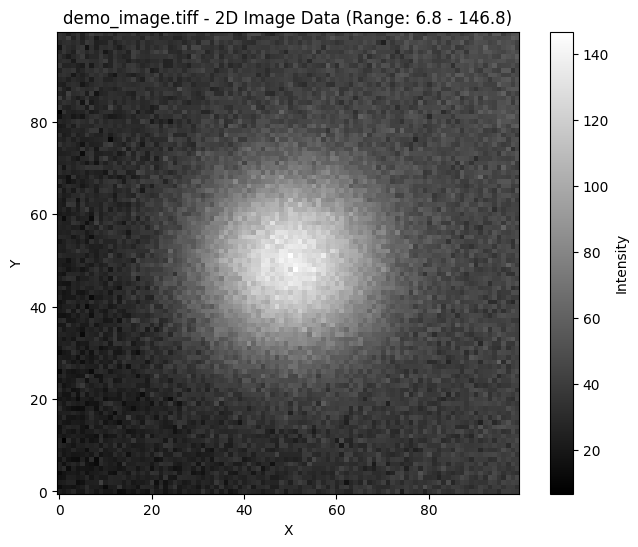


4. 调整亮度范围...
   - 重新显示调整亮度后的图像


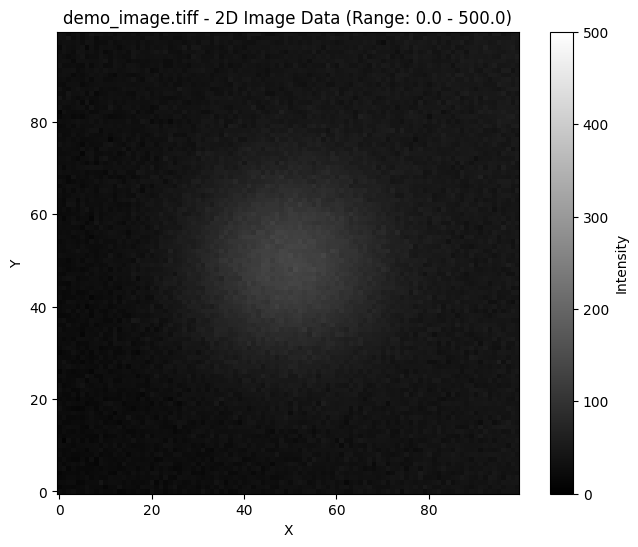


5. 数据旋转演示...
   - 旋转90度
数据已旋转90度，新尺寸: (100, 100)


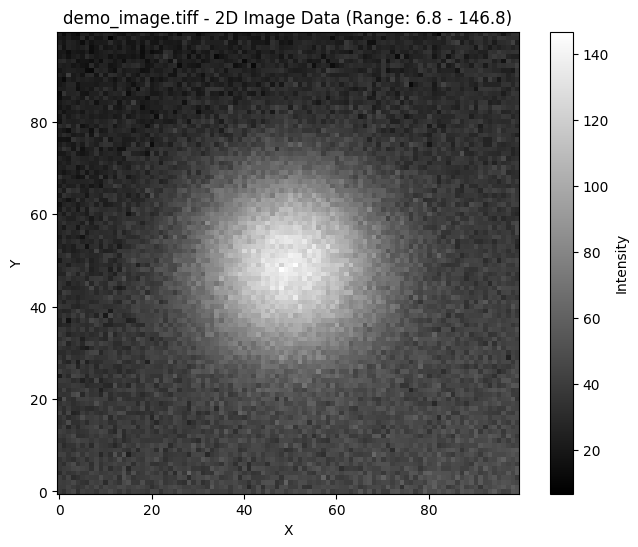


6. 背景校正演示...
   - 设置背景数据
背景数据已设置，尺寸: (100, 100)
背景文件: background.tiff
   - 执行背景校正
使用预设背景数据进行校正...
背景校正完成（使用背景数据）
   - 显示背景校正对比


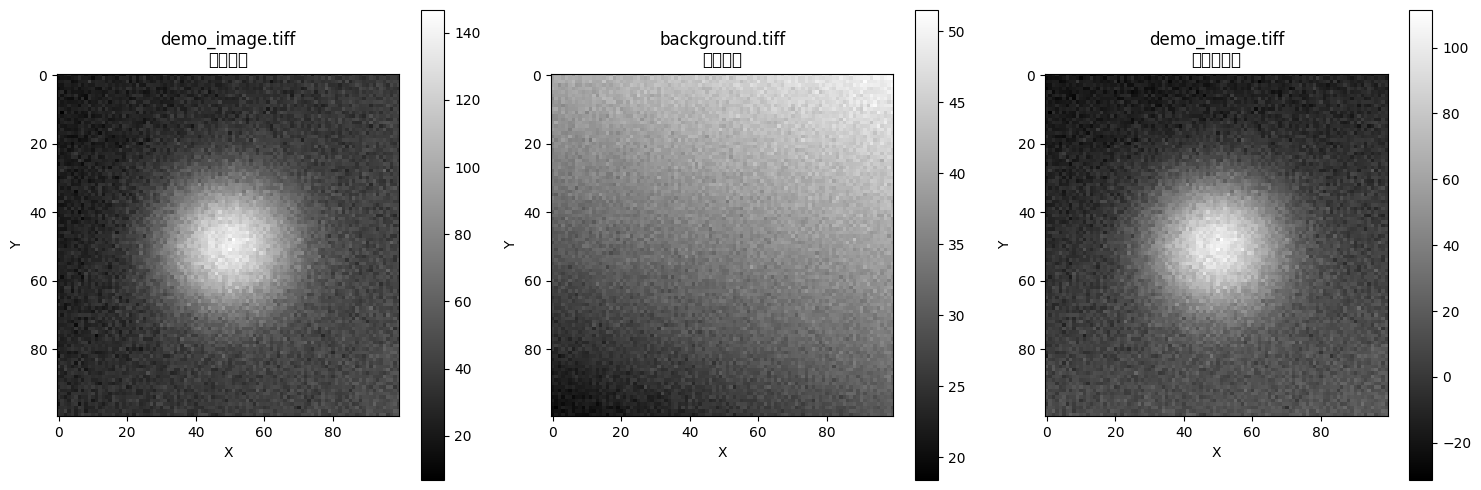


7. ROI选择演示...
   - 选择第一个ROI区域
ROI已截取并存储为ROI #0，尺寸: (35, 40)
当前roi_list中共有 1 个ROI
ROI范围: (20, 30) 到 (60, 65)


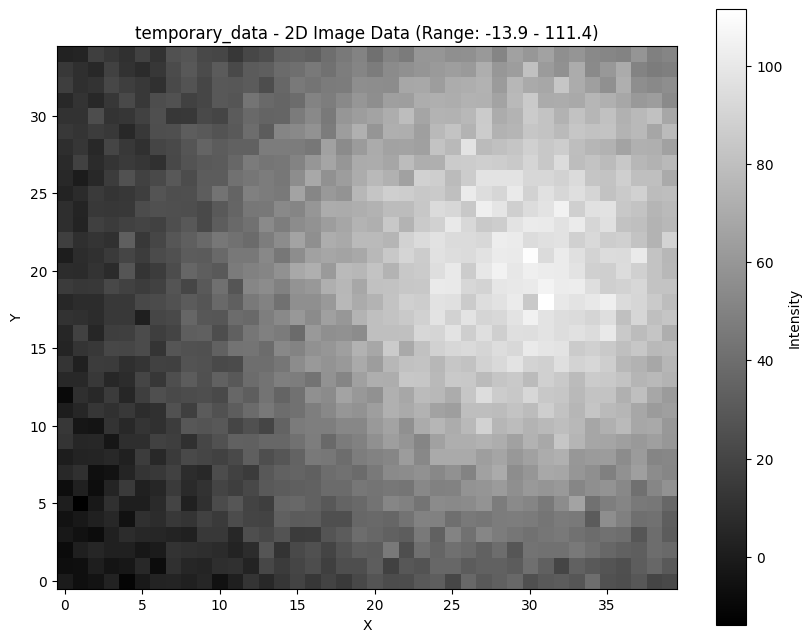

   - 选择第二个ROI区域
ROI已截取并存储为ROI #1，尺寸: (25, 25)
当前roi_list中共有 2 个ROI
ROI范围: (10, 10) 到 (35, 35)


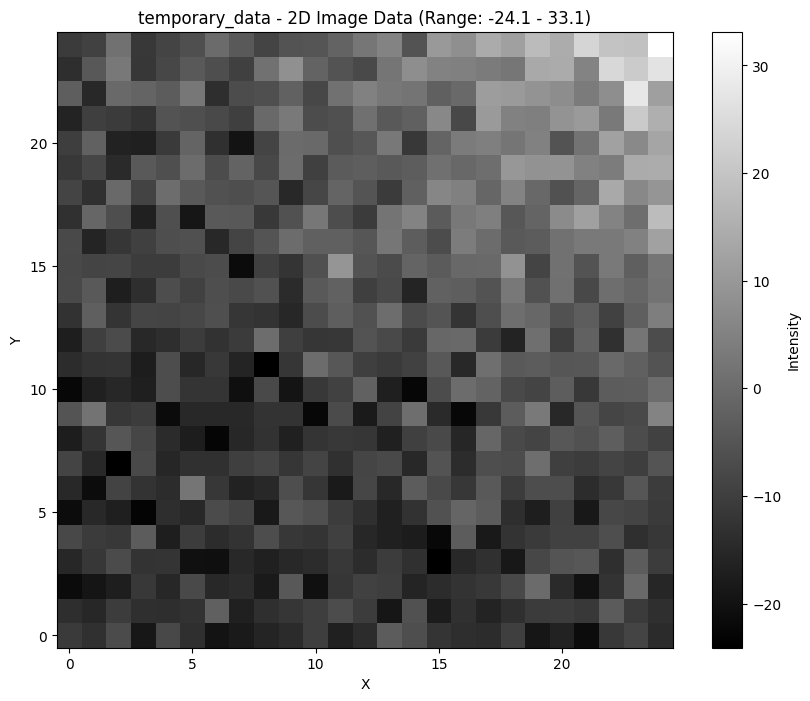

roi_list中共有 2 个ROI:
--------------------------------------------------
ROI #0: 尺寸 (35, 40), 数据范围 [-13.93, 111.40]
ROI #1: 尺寸 (25, 25), 数据范围 [-24.11, 33.14]

8. 数据切割演示...
   - 沿X轴切割数据
背景校正后数据已切割为 4 个块，沿 X 轴
   - 分析切割块的统计信息
数据块 0 统计信息:
  均值: -3.057
  标准差: 10.171
  方差: 103.439
  范围: [-31.275, 22.880]
  偏度: -0.062
  峰度: -0.786
----------------------------------------
数据块 1 统计信息:
  均值: 11.642
  标准差: 19.929
  方差: 397.163
  范围: [-26.743, 77.483]
  偏度: 0.701
  峰度: 0.544
----------------------------------------
数据块 2 统计信息:
  均值: 32.191
  标准差: 34.255
  方差: 1173.414
  范围: [-27.209, 111.403]
  偏度: 0.445
  峰度: -0.968
----------------------------------------
数据块 3 统计信息:
  均值: 15.606
  标准差: 19.627
  方差: 385.237
  范围: [-28.391, 83.690]
  偏度: 0.657
  峰度: 0.434
----------------------------------------

9. 数据降维演示...
   - 沿Y方向对切割块进行降维
已对 4 个数据块沿 Y 方向进行降维
   - 可视化1D数据


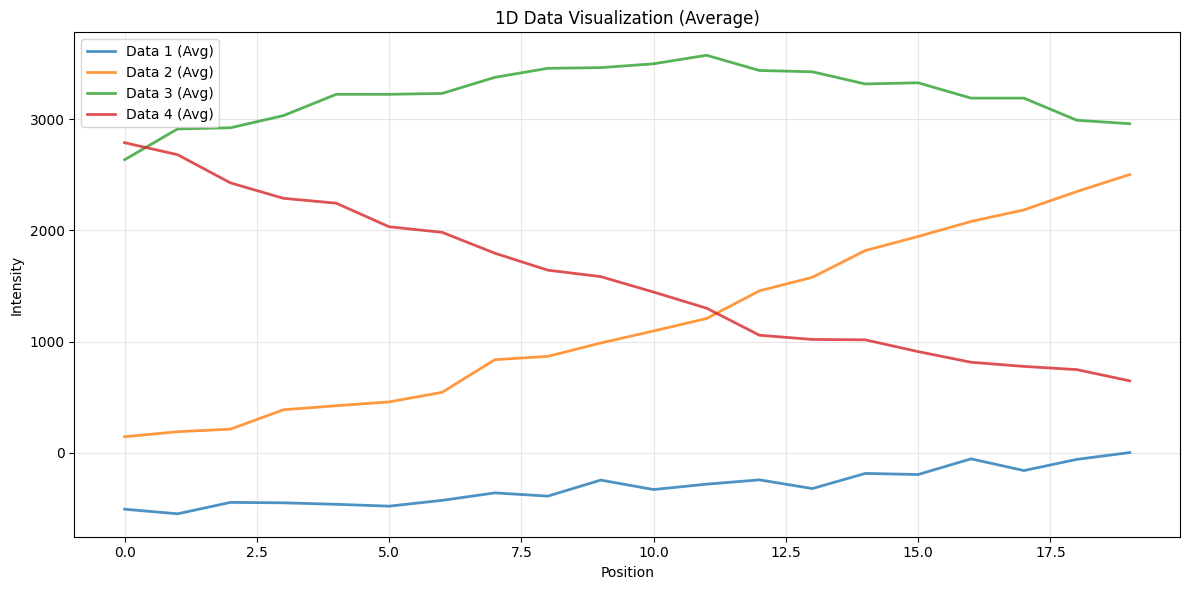


10. 批量可视化所有ROI...


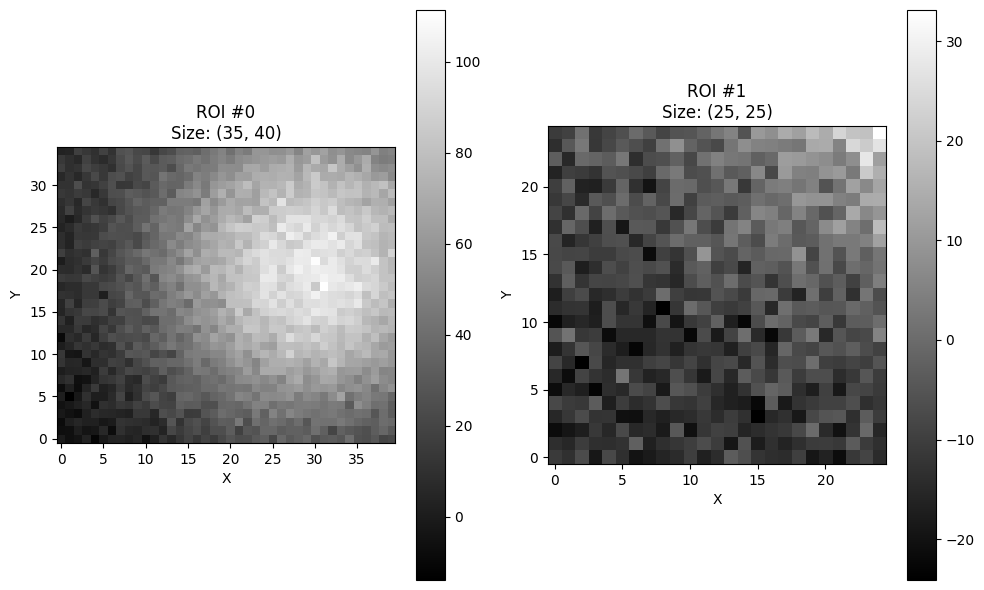


11. ROI管理演示...
   - 删除第一个ROI
已删除ROI #0，尺寸为 (35, 40)
当前roi_list中剩余 1 个ROI
剩余ROI重新编号为: #0
roi_list中共有 1 个ROI:
--------------------------------------------------
ROI #0: 尺寸 (25, 25), 数据范围 [-24.11, 33.14]

12. 数据导出演示...
   - 保存当前数据为CSV
数据已保存为CSV: demo_output.csv
   - 保存为图像格式
图像已保存为: demo_output.png

13. 重置背景校正...
背景校正已重置
   背景校正已重置

14. 其他背景校正方法演示...
   - 使用恒定值进行背景校正
使用预设背景数据进行校正...
背景校正完成（使用背景数据）


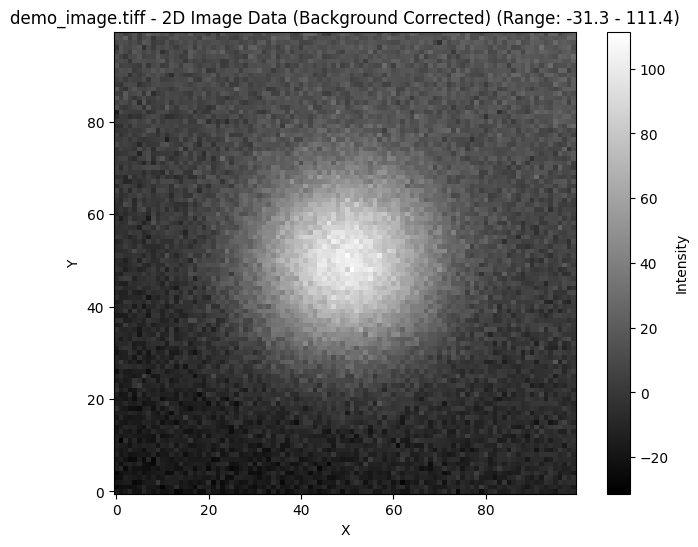

背景校正已重置
   - 使用指定区域进行背景校正
使用预设背景数据进行校正...
背景校正完成（使用背景数据）


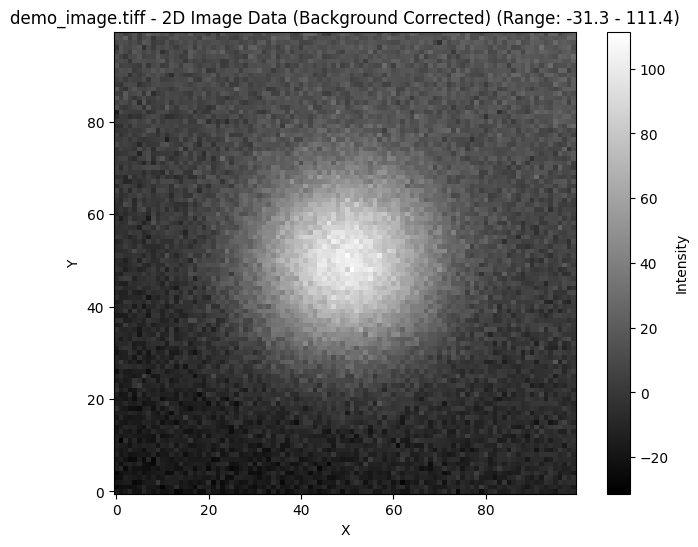


=== 演示完成 ===
ImageProcessor 类的主要功能已全部演示完毕！


'\n# 如果您有实际的TIFF文件，可以这样使用：\n\n# 读取TIFF文件\ndata_df, metadata = read_tiff_to_df("your_image.tiff")\nbackground_df, bg_metadata = read_tiff_to_df("your_background.tiff")\n\n# 创建处理器\nprocessor = ImageProcessor(original_data=data_df, metadata=metadata)\n\n# 设置背景并校正\nprocessor.set_background_data(background_df, "your_background.tiff")\nprocessor.remove_background()\n\n# 其他操作...\n'

In [5]:
# ImageProcessor 类使用演示
# 注意：这个演示假设您已经有了前面定义的 ImageProcessor 类

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==================== 创建模拟数据用于演示 ====================

def create_sample_data():
    """创建一些示例数据用于演示"""
    # 创建一个100x100的模拟图像数据
    np.random.seed(42)  # 为了结果可重现
    
    # 基础信号
    x = np.linspace(0, 10, 100)
    y = np.linspace(0, 10, 100)
    X, Y = np.meshgrid(x, y)
    
    # 创建一个带有峰值的2D高斯分布
    signal = 100 * np.exp(-((X-5)**2 + (Y-5)**2) / 4)
    
    # 添加一些噪声
    noise = np.random.normal(0, 5, signal.shape)
    
    # 添加背景
    background = 20 + 2 * X + Y
    
    # 最终数据
    data = signal + background + noise
    
    # 转换为DataFrame
    df = pd.DataFrame(data)
    
    # 创建一个单独的背景数据（稍有不同）
    background_data = background + np.random.normal(0, 1, background.shape)
    background_df = pd.DataFrame(background_data)
    
    return df, background_df

# ==================== 演示开始 ====================

print("=== ImageProcessor 类使用演示 ===\n")

# 1. 创建示例数据
print("1. 创建示例数据...")
sample_data, sample_background = create_sample_data()

# 2. 初始化 ImageProcessor
print("2. 初始化 ImageProcessor...")
processor = ImageProcessor(
    original_data=sample_data,
    metadata={'filename': 'demo_image.tiff', 'width': 100, 'height': 100}
)

print(f"   - 数据尺寸: {processor.original_data.shape}")
print(f"   - 文件名: {processor.filename}")
print(f"   - 亮度范围: {processor.brightness_range}")

# 3. 数据可视化
print("\n3. 数据可视化...")
print("   - 显示原始数据")
processor.visualize_data(figsize=(8, 6))

# 4. 亮度范围调整
print("\n4. 调整亮度范围...")
#processor.adjust_brightness_range(0, 500)
print("   - 重新显示调整亮度后的图像")
processor.visualize_data(brightness_range = [0,500], figsize=(8, 6))

# 5. 数据旋转
print("\n5. 数据旋转演示...")
print("   - 旋转90度")
processor.rotate_data(90)
processor.visualize_data(figsize=(8, 6))

# 6. 背景校正演示
print("\n6. 背景校正演示...")

# 6a. 设置背景数据
print("   - 设置背景数据")
# 注意：由于我们旋转了数据，需要旋转背景数据以匹配
rotated_background = pd.DataFrame(np.rot90(sample_background.values, k=1))
success = processor.set_background_data(rotated_background, "background.tiff")

if success:
    # 6b. 执行背景校正
    print("   - 执行背景校正")
    processor.remove_background()
    
    # 6c. 可视化背景校正结果
    print("   - 显示背景校正对比")
    processor.visualize_background_correction(figsize=(15, 5))

# 7. ROI选择演示
print("\n7. ROI选择演示...")
print("   - 选择第一个ROI区域")
roi1 = processor.select_roi(origin=(20, 30), width=40, height=35, 
                           store_roi=True, visualize=True)

print("   - 选择第二个ROI区域")
roi2 = processor.select_roi(origin=(10, 10), width=25, height=25, 
                           store_roi=True, visualize=True)

# 显示ROI信息
processor.get_roi_info()

# 8. 数据切割演示
print("\n8. 数据切割演示...")
print("   - 沿X轴切割数据")
processor.slice_data(axis='x', start=0, end=80, step=20)

print("   - 分析切割块的统计信息")
stats = processor.analyze_blocks_statistics()

# 9. 数据降维演示
print("\n9. 数据降维演示...")
print("   - 沿Y方向对切割块进行降维")
processor.integrate_blocks_along_dimension(direction='y')

print("   - 可视化1D数据")
processor.visualize_1d_data(figsize=(12, 6), take_avg=True)

# 10. 批量可视化ROI
print("\n10. 批量可视化所有ROI...")
processor.visualize_all_rois(figsize=(10, 6))

# 11. ROI管理演示
print("\n11. ROI管理演示...")
print("   - 删除第一个ROI")
processor.remove_roi(0)
processor.get_roi_info()

# 12. 数据导出演示
print("\n12. 数据导出演示...")
print("   - 保存当前数据为CSV")
processor.save_as_csv("demo_output.csv")

print("   - 保存为图像格式")
processor.save_as_image("demo_output.png", format='PNG')

# 13. 恢复原始数据
print("\n13. 重置背景校正...")
processor.reset_background_correction()
print("   背景校正已重置")

# 14. 其他背景校正方法演示
print("\n14. 其他背景校正方法演示...")

# 使用恒定值进行背景校正
print("   - 使用恒定值进行背景校正")
processor.remove_background(constant_value=25.0)
processor.visualize_data(figsize=(8, 6))

# 重置并尝试区域背景校正
processor.reset_background_correction()
print("   - 使用指定区域进行背景校正")
processor.remove_background(region_coords=(0, 10, 0, 10))
processor.visualize_data(figsize=(8, 6))

print("\n=== 演示完成 ===")
print("ImageProcessor 类的主要功能已全部演示完毕！")

# ==================== 实际文件读取演示（注释掉，需要实际文件） ====================
"""
# 如果您有实际的TIFF文件，可以这样使用：

# 读取TIFF文件
data_df, metadata = read_tiff_to_df("your_image.tiff")
background_df, bg_metadata = read_tiff_to_df("your_background.tiff")

# 创建处理器
processor = ImageProcessor(original_data=data_df, metadata=metadata)

# 设置背景并校正
processor.set_background_data(background_df, "your_background.tiff")
processor.remove_background()

# 其他操作...
"""

In [ ]:
# ==================== 全局容器 ====================

class ImageProcessorContainer:
    """
    全局容器，用于管理多个ImageProcessor实例
    """
    def __init__(self):
        self.processors = {}  # 存储所有processor实例
        self.current_name = None  # 当前活跃的processor名称
        
    def add_processor(self, name: str, processor: 'ImageProcessor') -> None:
        """添加processor到容器"""
        self.processors[name] = processor
        self.current_name = name
        print(f"已添加处理器 '{name}' 到容器")
        
    def get_processor(self, name: str = None) -> Optional['ImageProcessor']:
        """获取指定processor，None时返回当前活跃的"""
        if name is None:
            name = self.current_name
        return self.processors.get(name)
        
    def set_current(self, name: str) -> bool:
        """设置当前活跃的processor"""
        if name in self.processors:
            self.current_name = name
            print(f"当前处理器已设置为 '{name}'")
            return True
        else:
            print(f"处理器 '{name}' 不存在")
            return False
            
    def list_processors(self) -> None:
        """列出所有processor"""
        if not self.processors:
            print("容器中没有处理器")
            return
            
        print("容器中的处理器:")
        for name, processor in self.processors.items():
            status = " (当前)" if name == self.current_name else ""
            data_shape = processor.original_data.shape if not processor.original_data.empty else "空"
            print(f"  - {name}{status}: 数据尺寸 {data_shape}")
            
    def remove_processor(self, name: str) -> bool:
        """删除指定processor"""
        if name in self.processors:
            del self.processors[name]
            if self.current_name == name:
                self.current_name = list(self.processors.keys())[0] if self.processors else None
            print(f"已删除处理器 '{name}'")
            return True
        else:
            print(f"处理器 '{name}' 不存在")
            return False

# 创建全局容器实例
img_container = ImageProcessorContainer()

# ==================== ImageProcessor类的修改部分 ====================

# 在ImageProcessor类的__post_init__方法后添加新属性和方法
@dataclass
class ImageProcessor:
    # ... 原有属性保持不变 ...
    
    # 新增属性
    filename: str = field(default="")  # 存储当前数据的文件名
    background_filename: str = field(default="")  # 存储背景数据的文件名
    
    def __post_init__(self):
        """初始化后处理，设置默认亮度范围和当前数据"""
        if not self.original_data.empty:
            self.brightness_range = (
                float(self.original_data.min().min()),
                float(self.original_data.max().max())
            )
            self.current_data = self.original_data.copy()
        
        # 从metadata中提取文件名
        if self.metadata and 'filename' in self.metadata:
            import os
            self.filename = os.path.basename(self.metadata['filename'])
    
    def _extract_filename(self, filepath: str) -> str:
        """从文件路径中提取文件名"""
        import os
        return os.path.basename(filepath) if filepath else "no_filename"
    
    def visualize_data(self, input_img=None, figsize: Tuple[int, int] = (10, 8), 
                      brightness_range: Optional[Tuple[float, float]] = None,
                      custom_filename: str = None) -> None:
        """
        可视化2D数据, 支持亮度范围调整, 通过 input_img允许临时调用
        
        Args:
            input_img: 允许此函数优先临时调用以可视化任意的2D数据
            figsize: 图像大小
            brightness_range: 亮度范围 (min, max), None表示使用默认范围
            custom_filename: 临时调用时的自定义文件名
        """
        # 优先可视化 input_img
        if input_img is not None:
            current_data = input_img
            display_filename = custom_filename if custom_filename else "temporary_data"
        else:
            current_data = self.get_current_data()
            display_filename = self.filename if self.filename else "no_filename"
        
        if current_data.empty:
            print("没有数据可视化")
            return
        
        if brightness_range:
            self.brightness_range = brightness_range
        else:
            # 重新计算当前数据的亮度范围
            self.brightness_range = (
                float(current_data.min().min()),
                float(current_data.max().max())
            )
        
        plt.figure(figsize=figsize)
        plt.imshow(current_data.values, 
                  cmap='gray', 
                  vmin=self.brightness_range[0], 
                  vmax=self.brightness_range[1], 
                  origin='lower')
        plt.colorbar(label='Intensity')
        
        # 构建标题，包含文件名
        title = f'{display_filename} - 2D Image Data'
        if self.background_corrected and input_img is None:  # 只对主数据显示背景校正状态
            title += ' (Background Corrected)'
        title += f' (Range: {self.brightness_range[0]:.1f} - {self.brightness_range[1]:.1f})'
        
        plt.title(title)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
    
    def set_background_data(self, background_df: pd.DataFrame, 
                           background_filepath: str = "") -> bool:
        """
        设置背景数据并验证尺寸兼容性
        
        Args:
            background_df: 背景数据DataFrame
            background_filepath: 背景数据文件路径（用于提取文件名）
            
        Returns:
            bool: 尺寸是否匹配
        """
        if self.original_data.empty:
            print("错误：原始数据为空，无法设置背景")
            return False
            
        # 检查尺寸是否一致
        if background_df.shape == self.original_data.shape:
            self.background_data = background_df.copy()
            self.background_filename = self._extract_filename(background_filepath)
            print(f"背景数据已设置，尺寸: {background_df.shape}")
            if self.background_filename:
                print(f"背景文件: {self.background_filename}")
            return True
        else:
            print(f"警告：背景数据尺寸 {background_df.shape} 与原始数据尺寸 {self.original_data.shape} 不匹配")
            return False

    def visualize_background_correction(self, figsize: Tuple[int, int] = (15, 5)) -> None:
        """
        可视化背景校正前后的对比
        
        Args:
            figsize: 图像大小
        """
        if not self.background_corrected:
            print("尚未进行背景校正")
            return

        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # 原始数据
        im1 = axes[0].imshow(self.original_data.values, cmap='gray')
        original_title = f'{self.filename}\n原始数据' if self.filename else '原始数据'
        axes[0].set_title(original_title)
        axes[0].set_xlabel('X')
        axes[0].set_ylabel('Y')
        plt.colorbar(im1, ax=axes[0])
        
        # 背景数据（如果有）
        if not self.background_data.empty:
            im2 = axes[1].imshow(self.background_data.values, cmap='gray')
            bg_title = f'{self.background_filename}\n背景数据' if self.background_filename else '背景数据'
            axes[1].set_title(bg_title)
        else:
            # 显示背景校正的差值
            diff_data = self.original_data - self.processed_data
            im2 = axes[1].imshow(diff_data.values, cmap='gray')
            axes[1].set_title('移除的背景')
        axes[1].set_xlabel('X')
        axes[1].set_ylabel('Y')
        plt.colorbar(im2, ax=axes[1])
        
        # 校正后数据
        im3 = axes[2].imshow(self.processed_data.values, cmap='gray')
        corrected_title = f'{self.filename}\n背景校正后' if self.filename else '背景校正后'
        axes[2].set_title(corrected_title)
        axes[2].set_xlabel('X')
        axes[2].set_ylabel('Y')
        plt.colorbar(im3, ax=axes[2])
        
        plt.tight_layout()
        plt.show()

# ==================== 便捷函数 ====================

def load_and_create_processor(filepath: str, name: str = None) -> ImageProcessor:
    """
    加载图像文件并创建ImageProcessor实例，自动添加到全局容器
    
    Args:
        filepath: 图像文件路径
        name: 处理器名称，None时使用文件名
        
    Returns:
        ImageProcessor实例
    """
    # 读取图像数据
    df, metadata = read_image_to_df(filepath)
    
    if df.empty:
        print(f"加载文件失败: {filepath}")
        return None
    
    # 创建处理器
    processor = ImageProcessor(original_data=df, metadata=metadata)
    
    # 确定名称
    if name is None:
        import os
        name = os.path.splitext(os.path.basename(filepath))[0]
    
    # 添加到容器
    img_container.add_processor(name, processor)
    
    print(f"成功加载 {filepath}")
    print(f"数据尺寸: {df.shape}")
    
    return processor

def get_current_processor() -> Optional[ImageProcessor]:
    """获取当前活跃的processor"""
    return img_container.get_processor()

# ==================== 使用演示 ====================

def demo_usage():
    """
    演示ImageProcessor类的各种方法使用
    """
    print("=== ImageProcessor 使用演示 ===\n")
    
    # 1. 加载图像数据
    print("1. 加载图像数据")
    print("# 方法1: 直接加载")
    print("df, metadata = read_image_to_df('your_image.tiff')")
    print("processor = ImageProcessor(original_data=df, metadata=metadata)")
    print()
    print("# 方法2: 使用便捷函数（推荐）")
    print("processor = load_and_create_processor('your_image.tiff', 'main_data')")
    print()
    
    # 2. 基本可视化
    print("2. 基本数据可视化")
    print("processor.visualize_data()  # 显示原始数据")
    print("processor.visualize_data(brightness_range=(100, 200))  # 调整亮度范围")
    print()
    
    # 3. 数据旋转
    print("3. 数据旋转")
    print("processor.rotate_data(90)   # 逆时针旋转90度")
    print("processor.rotate_data(180)  # 旋转180度")
    print("processor.visualize_data()  # 查看旋转后结果")
    print()
    
    # 4. 背景校正
    print("4. 背景校正")
    print("# 方法1: 使用背景文件")
    print("bg_df, bg_meta = read_image_to_df('background.tiff')")
    print("processor.set_background_data(bg_df, 'background.tiff')")
    print("processor.remove_background()")
    print()
    print("# 方法2: 使用恒定值")
    print("processor.remove_background(constant_value=50)")
    print()
    print("# 方法3: 使用指定区域")
    print("processor.remove_background(region_coords=(0, 10, 0, 10))")
    print()
    print("# 可视化背景校正结果")
    print("processor.visualize_background_correction()")
    print()
    
    # 5. 数据切割和降维
    print("5. 数据切割和降维")
    print("# 沿X轴切割数据")
    print("processor.slice_data(axis='x', start=0, end=100, step=10)")
    print("print(f'切割得到 {len(processor.sliced_blocks)} 个数据块')")
    print()
    print("# 对切割数据进行降维")
    print("processor.integrate_blocks_along_dimension('y')  # 沿Y方向求和")
    print("processor.visualize_1d_data()  # 可视化1D结果")
    print()
    
    # 6. ROI操作
    print("6. ROI（感兴趣区域）操作")
    print("# 选择ROI区域")
    print("roi1 = processor.select_roi(origin=(10, 20), width=50, height=60)")
    print("roi2 = processor.select_roi(origin=(70, 80), width=40, height=40)")
    print()
    print("# 查看ROI信息")
    print("processor.get_roi_info()")
    print()
    print("# 批量可视化所有ROI")
    print("processor.visualize_all_rois()")
    print()
    print("# 删除指定ROI")
    print("processor.remove_roi(0)  # 删除第一个ROI")
    print("processor.clear_roi_list()  # 清空所有ROI")
    print()
    
    # 7. 统计分析
    print("7. 统计分析")
    print("# 对切割的数据块进行统计分析")
    print("stats = processor.analyze_blocks_statistics()")
    print("# stats包含每个数据块的均值、方差、标准差等统计信息")
    print()
    
    # 8. 数据导出
    print("8. 数据导出")
    print("processor.save_as_csv('output_data.csv')        # 保存为CSV")
    print("processor.save_as_image('output_image.png')     # 保存为图像")
    print("processor.save_as_parquet('output_data.parquet') # 保存为Parquet")
    print()
    
    # 9. 全局容器使用
    print("9. 全局容器使用")
    print("# 加载多个文件")
    print("proc1 = load_and_create_processor('image1.tiff', 'dataset1')")
    print("proc2 = load_and_create_processor('image2.tiff', 'dataset2')")
    print()
    print("# 管理多个处理器")
    print("img_container.list_processors()      # 列出所有处理器")
    print("img_container.set_current('dataset1') # 设置当前活跃处理器")
    print("current_proc = get_current_processor() # 获取当前处理器")
    print()
    
    # 10. 高级用法示例
    print("10. 完整工作流示例")
    print("""
# 完整的图像处理工作流
def process_image_workflow(image_path, background_path=None):
    # 1. 加载主图像
    processor = load_and_create_processor(image_path, 'main')
    
    # 2. 初始可视化
    processor.visualize_data()
    
    # 3. 背景校正（如果有背景文件）
    if background_path:
        bg_df, bg_meta = read_image_to_df(background_path)
        processor.set_background_data(bg_df, background_path)
        processor.remove_background()
        processor.visualize_background_correction()
    
    # 4. 选择感兴趣区域
    roi = processor.select_roi(origin=(50, 50), width=100, height=100)
    
    # 5. 数据切割和分析
    processor.slice_data(axis='x', start=0, end=roi.shape[1], step=10)
    processor.integrate_blocks_along_dimension('y')
    processor.visualize_1d_data()
    
    # 6. 统计分析
    stats = processor.analyze_blocks_statistics()
    
    # 7. 保存结果
    processor.save_as_csv('processed_data.csv')
    processor.save_as_image('processed_image.png')
    
    return processor
    """)

if __name__ == "__main__":
    demo_usage()